In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *

In [2]:
# from sensetools.plots import feature_labeller

In [3]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
# order = [(53, 'fixed_k'), (60, 'fixed_k'), (52, 'fixed_k'), (47, 'worst'), (81, 'timescale_gap'), (60, 'timescale_gap'), (86, 'timescale_gap')]
lag = 41

In [6]:
summary_path = f'../{protein}/summary_batch1.h5'

# selection = pd.read_hdf(summary_path, key='model_selection')
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

In [7]:
def feature_labeller(x): 
    if x['feature__value'] == 'dihedrals': 
        return 'dihedrals'
    elif x['feature__value'] == 'distances': 
        return f"{x['distances__transform']}-distances"

In [9]:
hp_samples = pd.read_hdf('../../experiments/hpsample.h5')

hp_samples.reset_index(inplace=True)

hp_samples['feature'] = hp_samples.apply(feature_labeller, axis=1)
vamps = vamps.merge(hp_samples.loc[:, ['feature', 'hp_ix']], on='hp_ix')
timescales = timescales.merge(hp_samples.loc[:, ['feature', 'hp_ix']], on='hp_ix')

In [10]:
def top_performers_by_feature(vamps: pd.DataFrame, k: int, lag: int)-> Dict[int, int]:
    df = vamps.loc[(vamps.process==k) & (vamps.lag==lag), ['hp_ix', 'median', 'feature']].copy()
    df['rank'] = df.groupby(['feature'])['median'].rank(ascending=False)
    df.sort_values(by='rank', inplace=True)
    d = dict(zip(df['hp_ix'], df['rank']))
    return d


def top_performers(vamps: pd.DataFrame, k: int, lag: int)-> Dict[int, int]:
    df = vamps.loc[(vamps.process==k) & (vamps.lag==lag), ['hp_ix', 'median']].copy()
    df['rank'] = df['median'].rank(ascending=False)
    df.sort_values(by='rank', inplace=True)
    d = dict(zip(df['hp_ix'], df['rank']))
    return d


def plot_val_by_mod_proc(ax, value_df, color='by_proc'): 
    labelled = False
    first_mod = value_df['rank'].min()
    
    for (mod_n, proc), df in value_df.groupby([ 'rank', 'process']):
        if mod_n == first_mod: 
            label = f"{proc}"
        else: 
            label = None
        
        if color=='by_proc':
            col = cols[proc-2]
        else: 
            col = color
#         if proc == 2: 
#             print(mod_n, df['median'])
        ax.hlines(df['median'],  mod_n-width, mod_n+width, color=col, label=label, lw=3)
        
        ax.fill_between([mod_n-width, mod_n+width], df['lb'], df['ub'], alpha=0.05, color=col)

        

## Select incongruous models

In [11]:
# Select observables and vamp scores
ranking_k = 2 # rank by this VAMp2 score
timescale_k = 2 # Select the timescale to judge the ranking by
plotting_k = 7 # plot up to this process

top_vamps = vamps.loc[(vamps.process==ranking_k) & (vamps.lag==lag), :].copy()
top_timescales = timescales.loc[(timescales.lag == lag), :].copy()

# rank models
rank_by_ix = top_performers(vamps, k=ranking_k, lag=lag)

# add ranks to observables/vamps
top_vamps[f'rank'] = top_vamps['hp_ix'].apply(lambda x: rank_by_ix.get(x))
top_timescales[f'rank'] = top_timescales['hp_ix'].apply(lambda x: rank_by_ix.get(x))


In [12]:
ts_df = top_timescales.sort_values(by=['rank'], inplace=False)
ts_df = ts_df.loc[ts_df.process == timescale_k, :]

bad_ix = []
for i, row1 in ts_df.iterrows():
    ts = row1['median']
    rank = row1['rank']
    ix = row1['hp_ix']
    
    tmp = []
    for j, row2 in ts_df.loc[ts_df['rank']>rank, :].iterrows(): 
        if row2['median'] > ts: 
            tmp.append(row2['hp_ix'])
            ts = row2['median']
            
    if len(tmp)>0: 
        tmp.append(ix)
        tmp = [tmp[-1]] + tmp[:-1]
        bad_ix.append(tuple(tmp))

sort_ix = np.argsort([len(x) for x in bad_ix])[::-1]
bad_ix_sorted = [bad_ix[i] for i in sort_ix]

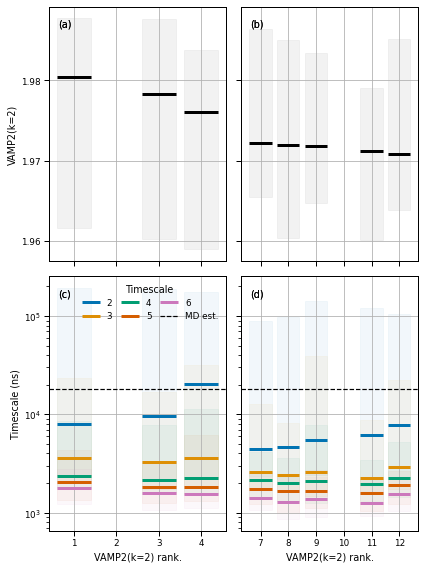

In [29]:
with sns.plotting_context('paper', font_scale=1): 
    width =0.4
    offset = 0.5
    fig, axes = plt.subplots(2, 2, figsize=(6, 8), sharex='col', sharey='row')
    
    cols = sns.color_palette('colorblind', timescales.process.max())

    for col_ix, bad_set in enumerate([bad_ix[0], bad_ix_sorted[1]]):

        use_ts = top_timescales.loc[top_timescales.hp_ix.isin(bad_set), :]
        use_ts = use_ts.loc[use_ts.process < plotting_k, :]
        use_vamps = top_vamps.loc[top_vamps.hp_ix.isin(bad_set), :]

        # Plot VAMPS
        vamp_ax = axes[0, col_ix]
        plot_val_by_mod_proc(vamp_ax, use_vamps, color='k')
        vamp_ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))

        # Plot timescales
        time_ax = axes[1, col_ix]
        plot_val_by_mod_proc(time_ax, use_ts)
        time_ax.set_yscale('log')

        # MD timescle
        xlim = time_ax.get_xlim()    
        time_ax.hlines(md_t2[protein], *xlim, color='k',ls='dashed', label='MD est.')
        time_ax.set_xlim(xlim)
        
        # labels
        if col_ix == 0:
            time_ax.set_ylabel('Timescale (ns)')
            vamp_ax.set_ylabel(f'VAMP2(k={ranking_k})')
        axes[-1, col_ix].set_xlabel(f'VAMP2(k={ranking_k}) rank.')
        
        # Legend
        h, l = axes[-1, -1].get_legend_handles_labels()
        axes[-1, 0].legend(h, l, bbox_to_anchor=(1, 1), loc='upper right', 
                           title='Timescale', ncol=3, framealpha=0.5, 
                          columnspacing=1, frameon=False)
        
        # Grid
        axes[0, col_ix].grid()
        axes[1, col_ix].grid()
        letters = list('abcd')
        for i, ax in enumerate(axes.flatten()):
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
            ax.annotate(text=f"({letters[i]})", xy=(0.05, 0.95), 
                        xycoords='axes fraction', ha='left',va='top')
        plt.tight_layout()
        plt.savefig(f'../{protein}/bad_vamp_ranks_all.pdf', bbox_inches='tight')

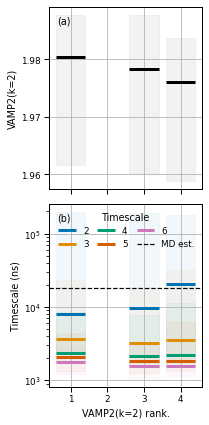

In [31]:
with sns.plotting_context('paper', font_scale=1): 
    width =0.4
    offset = 0.5
    fig, axes = plt.subplots(2, 1, figsize=(3, 6), sharex='col', sharey='row')
    axes = axes.reshape(-1, 1)
    
    cols = sns.color_palette('colorblind', timescales.process.max())

    for col_ix, bad_set in enumerate([bad_ix[0]]):

        use_ts = top_timescales.loc[top_timescales.hp_ix.isin(bad_set), :]
        use_ts = use_ts.loc[use_ts.process < plotting_k, :]
        use_vamps = top_vamps.loc[top_vamps.hp_ix.isin(bad_set), :]

        # Plot VAMPS
        vamp_ax = axes[0, col_ix]
        plot_val_by_mod_proc(vamp_ax, use_vamps, color='k')
        vamp_ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))

        # Plot timescales
        time_ax = axes[1, col_ix]
        plot_val_by_mod_proc(time_ax, use_ts)
        time_ax.set_yscale('log')

        # MD timescle
        xlim = time_ax.get_xlim()    
        time_ax.hlines(md_t2[protein], *xlim, color='k',ls='dashed', label='MD est.')
        time_ax.set_xlim(xlim)
        
        # labels
        if col_ix == 0:
            time_ax.set_ylabel('Timescale (ns)')
            vamp_ax.set_ylabel(f'VAMP2(k={ranking_k})')
        axes[-1, col_ix].set_xlabel(f'VAMP2(k={ranking_k}) rank.')
        
        # Legend
        h, l = axes[-1, -1].get_legend_handles_labels()
        axes[-1, 0].legend(h, l, bbox_to_anchor=(1, 1), loc='upper right', 
                           title='Timescale', ncol=3, framealpha=0.5, 
                          columnspacing=1, frameon=False)
        
        # Grid
        axes[0, col_ix].grid()
        axes[1, col_ix].grid()
        letters = list('abcd')
        for i, ax in enumerate(axes.flatten()):
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
            ax.annotate(text=f"({letters[i]})", xy=(0.05, 0.95), 
                        xycoords='axes fraction', ha='left',va='top')
        plt.tight_layout()
        plt.savefig(f'../{protein}/bad_vamp_ranks.pdf', bbox_inches='tight')

In [15]:
# x = np.linspace(0, 20, 100)
# def logistic(x, c, s): 
#     return 1/(1+np.exp(-s*(x-c)))


# y1 = logistic(x, 7, .5)
# y2 = logistic(x, 10, 5)


# plt.plot(x, y1, label='c, s = 7, 0.5')
# plt.plot(x, y2, label='c, s = 10, 5')
# plt.legend()
# plt.xlabel('Conctact distance, d, (Ang.)')
# plt.ylabel('Logistic distance')
# plt.savefig('logstic_explainer.pdf', bbox_inches='tight')